# Import Libraries and Dataset

In [2]:
import pandas as pd

df = pd.read_csv('./Cleaned_Data.csv')
df.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,PhysicalActivity,SleepTime,Asthma,...,Diabetic_No,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,HeartDisease
0,16.60,1,0,0,3,30,0,1,5,1,...,0,0,1,0,0,0,0,0,1,0
1,20.34,0,0,1,0,0,0,1,7,0,...,1,0,0,0,0,0,0,0,1,0
2,26.58,1,0,0,20,30,0,1,8,1,...,0,0,1,0,0,1,0,0,0,0
3,24.21,0,0,0,0,0,0,0,6,0,...,1,0,0,0,0,0,1,0,0,0
4,23.71,0,0,0,28,0,1,1,8,0,...,1,0,0,0,0,0,0,0,1,0


In [3]:
for cols in df.columns:
    df[cols] = df[cols].astype(float)

In [4]:
df.PhysicalHealth.unique()

array([ 3.,  0., 20., 28.,  6., 15.,  5., 30.,  7.,  1.,  2., 21.,  4.,
       10., 14., 18.,  8., 25., 16., 29., 27., 17., 24., 12., 23., 26.,
       22., 19.,  9., 13., 11.])

In [5]:
df['HeartDisease'].value_counts()

0.0    292422
1.0     27373
Name: HeartDisease, dtype: int64

# Feature Engineering

### InterQuartile Range for Outlier Detection and Removal

In [6]:
df.SkinCancer.describe()

count    319795.000000
mean          0.093244
std           0.290775
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: SkinCancer, dtype: float64

In [11]:
def IQR_outliers(df_, col):
    Q1 = df_[col].quantile(0.25)
    Q3 = df_[col].quantile(0.75)
    
    IQR = Q3 - Q1
    floor = Q1 - 1.85*IQR
    ceiling = Q3 + 1.85*IQR
    
    print(df_[(df_[col] < floor) | (df_[col] > ceiling)].shape)
    
    return df_[(df_[col] > floor) & (df_[col] < ceiling)]

In [8]:
# Columns that are non-binary
cols = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']

In [12]:
df2 = df.copy()
for C in cols:
    df2 = IQR_outliers(df2, C)

(6229, 42)
(45077, 42)
(38407, 42)
(2276, 42)


In [13]:
df.shape, df2.shape

((319795, 42), (227806, 42))

### Compare distributions pre and post outlier removal

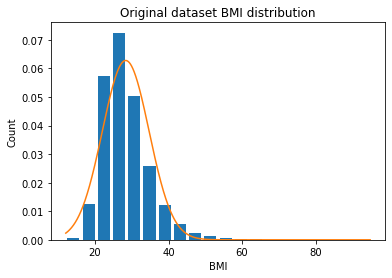

In [14]:
from scipy.stats import norm
import numpy as np
from matplotlib import pyplot as plt

plt.hist(df.BMI, bins=20, rwidth=0.8, density=True)
plt.title('Original dataset BMI distribution')
plt.xlabel('BMI')
plt.ylabel('Count')

rng = np.arange(df.BMI.min(), df.BMI.max(), 0.01)
plt.plot(rng, norm.pdf(rng, df.BMI.mean(),df.BMI.std()))

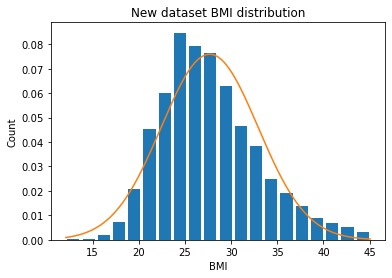

In [15]:
plt.hist(df2.BMI, bins=20, rwidth=0.8, density=True)
plt.title('New dataset BMI distribution')
plt.xlabel('BMI')
plt.ylabel('Count')

rng = np.arange(df2.BMI.min(), df2.BMI.max(), 0.01)
plt.plot(rng, norm.pdf(rng, df2.BMI.mean(),df2.BMI.std()))

#### Distribution relative dependent variable

In [16]:
def plot_histogram_dv(x,y):
    plt.hist(list(x[y==0]), alpha=0.5, label='HeartDisease=0')
    plt.hist(list(x[y==1]), alpha=0.5, label='HeartDisease=1')
    plt.title('Histogram of {x.name}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()

Old dataset

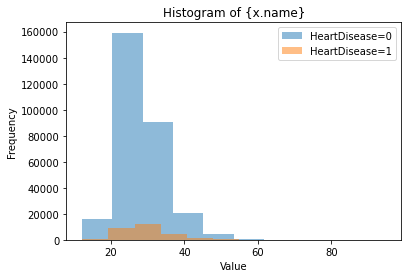

In [17]:
plot_histogram_dv(df['BMI'], df.iloc[:, -1])

New dataset

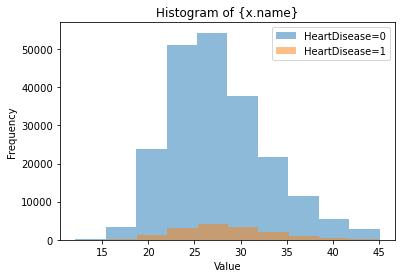

In [18]:
plot_histogram_dv(df2['BMI'], df2.iloc[:, -1])

# Train Test Split

Old dataset

In [21]:
X_old, y_old = df.iloc[:, :-1], df.iloc[:, -1]
(X_old.shape, y_old.shape)

((319795, 41), (319795,))

In [22]:
from sklearn.model_selection import train_test_split

X_old_train, X_old_test, y_old_train, y_old_test = train_test_split(
    X_old, y_old, test_size=0.2, random_state=42)

X_old_train.shape, X_old_test.shape

((255836, 41), (63959, 41))

New dataset

In [23]:
X, y = df2.iloc[:, :-1], df2.iloc[:, -1]
(X.shape, y.shape)

((227806, 41), (227806,))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((182244, 41), (45562, 41))

# Comparing Accuracy for Old & New Dataset

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf1 = RandomForestClassifier(max_depth=5, random_state=42)
clf1.fit(X_old_train, y_old_train)

y_old_pred1 = clf1.predict(X_old_test)

print(f'Old dataset accuracy: {accuracy_score(y_old_test,y_old_pred1)}')

Old dataset accuracy: 0.9126784346221798


In [32]:
clf2 = RandomForestClassifier(max_depth=5, random_state=42)
clf2.fit(X_train, y_train)

y_pred1 = clf1.predict(X_test)

print(f'New dataset accuracy: {accuracy_score(y_test,y_pred1)}')

New dataset accuracy: 0.9312585048944295


In [ ]:
%timeit function_call()

# L1 Regularization as Feature Selection

Selecting features using Lasso regularisation using ***SelectFromModel***

L1 regularization shrinks the coefficients of the model features/parameters to zero if they are not significant, therefore those features can be removed from the model

In [50]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

sel_ = SelectFromModel(LogisticRegression(C=0.01, penalty='l1', solver='liblinear'))
# Note: the higher the value of C the result of regularization will be less and vice versa

sel_.fit(X_train, y_train)

SelectFromModel(estimator=LogisticRegression(C=0.01, penalty='l1',
                                             solver='liblinear'))

In [51]:
sel_.get_feature_names_out()

array(['Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth',
       'MentalHealth', 'DiffWalking', 'PhysicalActivity', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer', 'Sex_Male',
       'AgeCategory_18-24', 'AgeCategory_25-29', 'AgeCategory_30-34',
       'AgeCategory_35-39', 'AgeCategory_40-44', 'AgeCategory_45-49',
       'AgeCategory_60-64', 'AgeCategory_65-69', 'AgeCategory_70-74',
       'AgeCategory_75-79', 'AgeCategory_80 or older', 'Race_Black',
       'Race_White', 'Diabetic_No', 'Diabetic_Yes', 'GenHealth_Excellent',
       'GenHealth_Fair', 'GenHealth_Good', 'GenHealth_Very good'],
      dtype=object)

In [52]:
len(sel_.get_feature_names_out())

31

In [53]:
sel_.get_support()

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True, False,
       False,  True, False, False,  True,  True, False,  True, False,
        True,  True,  True, False,  True])

In [54]:
# These variables hold the regularized training datasets
X_train_reg = sel_.transform(X_train)
X_test_reg = sel_.transform(X_test)

In [55]:
X_train_reg.shape, X_train.shape

((182244, 31), (182244, 41))

In [56]:
X_test_reg.shape, X_test.shape

((45562, 31), (45562, 41))

# Testing the Reduced Dataset

In [57]:
def regularized():
    clf_reg = RandomForestClassifier(max_depth=5, random_state=42)
    clf_reg.fit(X_train_reg, y_train)

    y_pred_reg = clf_reg.predict(X_test_reg)

    print(accuracy_score(y_test,y_pred_reg))

In [58]:
%timeit regularized()

0.9312365567797726
0.9312365567797726
0.9312365567797726
0.9312365567797726
0.9312365567797726
0.9312365567797726
0.9312365567797726
0.9312365567797726
2.67 s ± 18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [59]:
def non_regularized():
    clf2 = RandomForestClassifier(max_depth=5, random_state=42)
    clf2.fit(X_train, y_train)

    y_pred1 = clf1.predict(X_test)

    print(f'New dataset accuracy: {accuracy_score(y_test,y_pred1)}')

In [60]:
%timeit non_regularized()

New dataset accuracy: 0.9312585048944295
New dataset accuracy: 0.9312585048944295
New dataset accuracy: 0.9312585048944295
New dataset accuracy: 0.9312585048944295
New dataset accuracy: 0.9312585048944295
New dataset accuracy: 0.9312585048944295
New dataset accuracy: 0.9312585048944295
New dataset accuracy: 0.9312585048944295
3.23 s ± 9.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Conclusion

After reducing the number of features from 42 to 31 we see almost no difference in accuracy between the reduced and non-reduced dataset yet a massive increase in training speed as would be predicted when reducing the number of features.